<a href="https://colab.research.google.com/github/maxrgnt/pythdc2-project2/blob/master/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Panel Data
import pandas as pd
# System folders
import os
from pathlib import Path
# Visualization
import plotly.graph_objs as go
import seaborn as sns
%matplotlib inline

In [3]:
# read in the data
url='https://raw.githubusercontent.com/maxrgnt/pythdc2-project2/master/data/borderCrossing.csv'
df = pd.read_csv(url)
df.sample(3)

,Unnamed: 0,Abrv,State,Longitude,Latitude,Border,Date,Measure,Value
22908,22908,AL,Alaska,-135.16000,59.63000,US-Canada Border,11/1/2013 0:00,Train Passengers,0
4567,4567,ND,North Dakota,-97.91778,48.92333,US-Canada Border,9/1/2017 0:00,Personal Vehicle Passengers,5843
24754,24754,CA,California,-117.03000,32.54000,US-Mexico Border,7/1/2013 0:00,Train Passengers,0


In [4]:
# are there any null values?
df.isnull().sum()

Unnamed: 0    0
Abrv          0
State         0
Longitude     0
Latitude      0
Border        0
Date          0
Measure       0
Value         0
dtype: int64

In [0]:
# Handle the Date column
df['newDate'] = pd.to_datetime(df['Date'])

In [6]:
# Inspect the date column
df['Year'] = df['newDate'].dt.year
df['Month'] = df['newDate'].dt.month
# How many years of data available?
maxYear = df['newDate'].dt.year.max()
minYear = df['newDate'].dt.year.min()
print(f'From {minYear} to {maxYear} for total of {maxYear-minYear} year(s) of data.')

From 1996 to 2019 for total of 23 year(s) of data.


In [0]:
# df.groupby(['Border','Year'])[['Value']].sum().head()
# df = df.sample(10000)
df2 = df.groupby('StateAbrv')[['Value']].sum().reset_index()
df2.head()

,StateAbrv,Value
0,AL,10687909
1,AZ,664433912
2,CA,1770174503
3,ID,11048350
4,ME,138145359


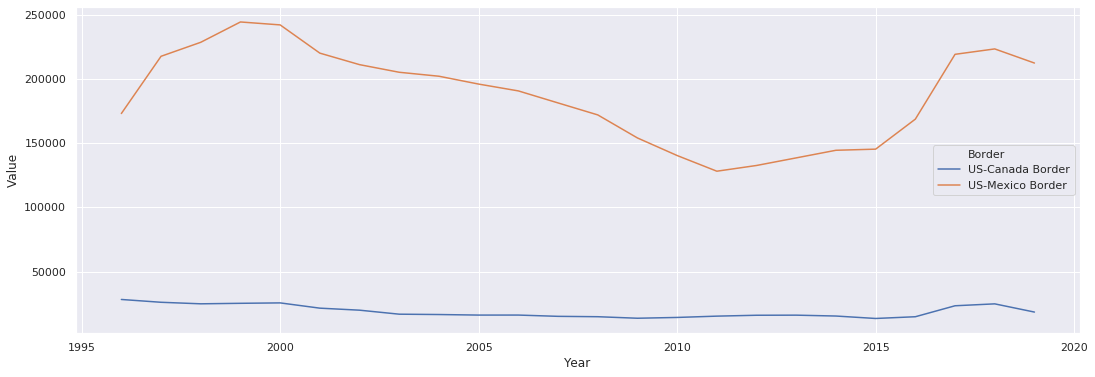

In [0]:
sns.set(rc={'figure.figsize':(18,6)})
sns.lineplot(x = 'Year', y = 'Value', hue = 'Border', ci=None, data = df);

In [0]:
# mapbox_access_token = open("assets/mytoken.mapbox_token").read()

# fig = go.Figure(go.Scattermapbox(
#     lat=df['Latitude'],
#     lon=df['Longitude'],
#     mode='markers',
#     marker=go.scattermapbox.Marker(
#         size=20,
#         colorscale='Purples',
#         color=df['Value']
#     ),
#     text=df['Value']

# ))
# fig.update_layout(
#     autosize=True,
#     hovermode='closest',
#     mapbox=go.layout.Mapbox(
#         accesstoken=mapbox_access_token,
#         bearing=0,
#         center=go.layout.mapbox.Center(
#             lat=39.8283,
#             lon=-98.5795
#         ),
#         pitch=0,
#         zoom=3
#     ),
# )
# fig

In [0]:
fig = go.Figure(data=go.Choropleth(
    locations=df2['StateAbrv'], # Spatial coordinates
    z = df2['Value'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Purples',
    colorbar_title = "Pedestrians",
))

fig.update_layout(
    title_text = 'Migration',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

In [0]:
brdr = df[["StateAbrv","Year","Value"]]
brdr = brdr[brdr['StateAbrv']=='TX']
brdr = brdr.groupby(['Year','StateAbrv'])[['Value']].sum().reset_index()

url='https://raw.githubusercontent.com/maxrgnt/pythdc2-project2/master/data/pctChangeGDP.csv# read in the data'
gdp_raw = pd.read_csv(url)
gdp_raw.sample(2)

,GeoFips,GeoName,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
4,5000,Arkansas,9.4,7.2,9.5,5.4,11.2,9.2,7.0,11.6,14.2,16.4,9.9,9.9,14.8,10.8,15.1,9.3,6.2,12.9,2.8,7.5,12.5,3.0,5.0,6.1,7.2,6.1,4.2,7.5,8.3,5.7,8.1,6.2,6.2,4.1,4.3,7.0,2.9,2.7,4.7,5.8,8.2,5.9,5.3,2.7,2.1,-1.9,4.8,4.3,2.5,5.1,2.7,1.0,1.3,3.0,3.5
6,8000,Colorado,5.1,6.5,9.7,5.4,11.4,11.0,10.0,15.0,14.9,16.9,10.7,13.0,10.4,14.3,15.6,14.9,13.5,14.7,8.4,6.4,10.9,6.1,2.2,4.8,6.0,5.1,6.2,5.6,9.4,9.6,9.2,7.8,7.4,10.0,10.0,9.2,10.0,3.9,1.8,2.9,3.8,7.8,5.1,6.4,3.9,-2.7,2.6,3.6,3.4,5.4,6.3,3.9,3.4,5.5,6.2


In [0]:
gdp = gdp[gdp['StateAbrv']=='TX'].reset_index()

(60, 56)
(15, 56)


In [0]:
print(f'GDP shape: {gdp.shape}')
print(f'Border crossing shape: {brdr.shape}')

GDP shape: (55, 4)
Border crossing shape: (24, 3)


In [0]:
print(f'Border crossing goes from {brdr["Year"].min()} to {brdr["Year"].max()}')
print(f'GDP goes from {gdp["Year"].min()} to {gdp["Year"].max()}')

Border crossing goes from 1996 to 2019
GDP goes from 1964 to 2018


In [0]:
gdp = gdp[gdp['Year'].astype(int)>1996]
brdr = brdr[brdr['Year'].astype(int)<2019]

In [0]:
print(f'Border crossing goes from {brdr["Year"].min()} to {brdr["Year"].max()}')
print(f'GDP goes from {gdp["Year"].min()} to {gdp["Year"].max()}')

Border crossing goes from 1996 to 2018
GDP goes from 1997 to 2018


In [0]:
gdp.rename(columns={'Value':'gdp'}, inplace=True)
brdr.rename(columns={'Value':'immigrants'}, inplace=True)

In [0]:
gdp.head(3)

,index,StateAbrv,Year,gdp
33,507,TX,1997,10.1
34,522,TX,1998,5.8
35,537,TX,1999,5.5


In [0]:
brdr['immigrants'] = brdr['immigrants'].astype(float)

In [0]:
for y in list(brdr['Year'].unique()):
  blah = 1.0
  if y != brdr['Year'].min():
    t0 = brdr.loc[brdr['Year'] == y-1,'immigrants'].tolist()[0]
    t1 = brdr.loc[brdr['Year'] == y,'immigrants'].tolist()[0]
    brdr.loc[brdr['Year'] == y, 'pct'] = (1-t1/t0)*100
brdr = brdr[brdr['Year'].astype(int)>brdr['Year'].min()]

In [0]:
print(brdr)
print(gdp)

    Year StateAbrv   immigrants        pct
1   1997        TX  144112883.0  -5.411652
2   1998        TX  150696714.0  -4.568524
3   1999        TX  163180976.0  -8.284362
4   2000        TX  158331350.0   2.971931
5   2001        TX  139030419.0  12.190214
6   2002        TX  125895151.0   9.447766
7   2003        TX  119902414.0   4.760102
8   2004        TX  120122963.0  -0.183940
9   2005        TX  115806714.0   3.593192
10  2006        TX  112021593.0   3.268481
11  2007        TX  107147439.0   4.351084
12  2008        TX  105485182.0   1.551374
13  2009        TX   92676707.0  12.142440
14  2010        TX   82225341.0  11.277231
15  2011        TX   70242948.0  14.572628
16  2012        TX   72898341.0  -3.780298
17  2013        TX   76715712.0  -5.236568
18  2014        TX   80334766.0  -4.717487
19  2015        TX   82726100.0  -2.976711
20  2016        TX   85714503.0  -3.612406
21  2017        TX   86196612.0  -0.562459
22  2018        TX   88404201.0  -2.561109
    index S

In [0]:
gdp['Year'] = gdp['Year'].astype(int)
new = gdp.merge(brdr, how = 'left', left_on='Year', right_on='Year',sort=True)

In [0]:
new

,index,StateAbrv_x,Year,gdp,StateAbrv_y,immigrants,pct
0,507,TX,1997,10.1,TX,144112883.0,-5.411652
1,522,TX,1998,5.8,TX,150696714.0,-4.568524
2,537,TX,1999,5.5,TX,163180976.0,-8.284362
3,552,TX,2000,8.4,TX,158331350.0,2.971931
4,567,TX,2001,4.6,TX,139030419.0,12.190214
5,582,TX,2002,1.8,TX,125895151.0,9.447766
6,597,TX,2003,5.4,TX,119902414.0,4.760102
7,612,TX,2004,9.2,TX,120122963.0,-0.183940
8,627,TX,2005,8.8,TX,115806714.0,3.593192
9,642,TX,2006,10.0,TX,112021593.0,3.268481


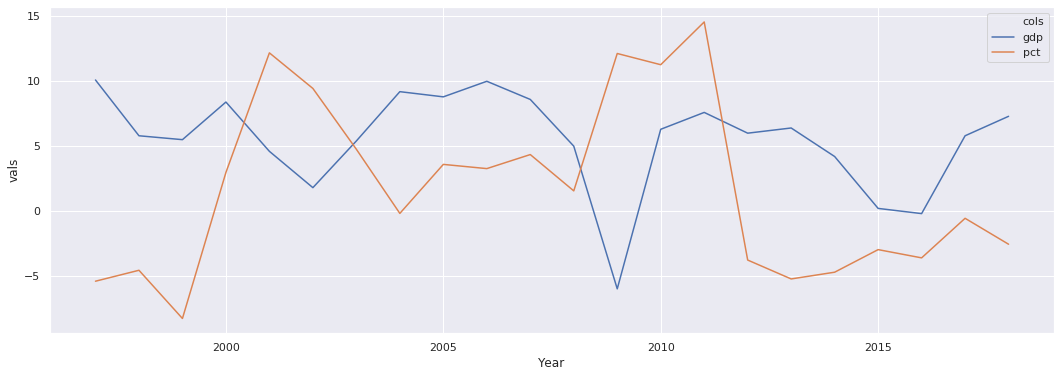

In [0]:
new = new.melt(['index','StateAbrv_x','Year','StateAbrv_y','immigrants'], var_name='cols', value_name='vals')
sns.set(rc={'figure.figsize':(18,6)})
sns.lineplot(x = 'Year', y = 'vals', hue='cols', ci=None, data = new);

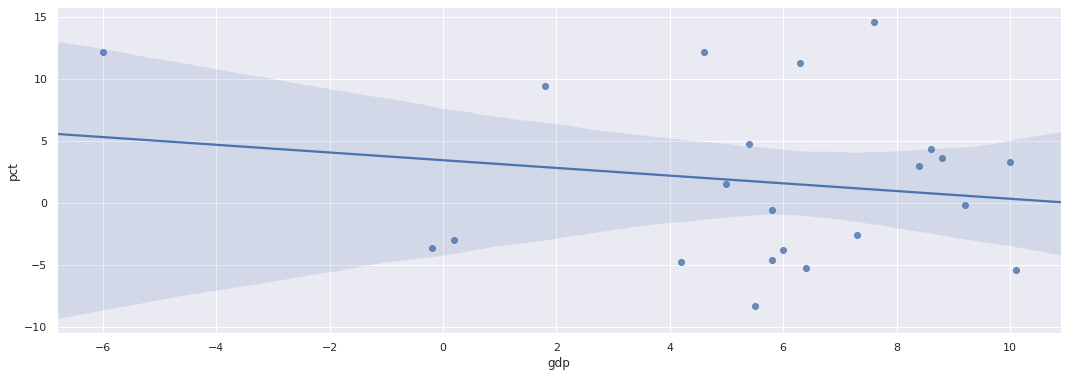

In [0]:
sns.regplot(x = 'gdp', y = 'pct', data = new, );